In [2]:
import os
from dotenv import load_dotenv

load_dotenv()

True

In [3]:
from langchain_openai import ChatOpenAI
# set by default env OPENAI_API_KEY
llm = ChatOpenAI(model="gpt-4o", temperature=0.5, max_tokens=2000)
llm.invoke("Hola quien eres tu?")

AIMessage(content='¡Hola! Soy un modelo de lenguaje desarrollado por OpenAI, conocido como ChatGPT. Estoy aquí para ayudarte a responder preguntas, proporcionar información y mantener conversaciones sobre una amplia variedad de temas. ¿En qué puedo ayudarte hoy?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 46, 'prompt_tokens': 12, 'total_tokens': 58, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_523b9b6e5f', 'finish_reason': 'stop', 'logprobs': None}, id='run-a6eb0d32-cd4a-4206-b841-5f650795bea8-0', usage_metadata={'input_tokens': 12, 'output_tokens': 46, 'total_tokens': 58, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [7]:
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END, MessagesState
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import ToolNode, tools_condition

class State(MessagesState):
    my_var: str

def multiply(a: int, b:int) -> int:
    """Multitply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

def add(a: int, b:int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

tools = [multiply, add]
llm = llm.bind_tools(tools, parallel_tool_calls=False)
llm.invoke("Hola, cuanto es dos veces veinte")



AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_y51otKvcdeEoV5H3yMnuklBB', 'function': {'arguments': '{"a":2,"b":20}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 90, 'total_tokens': 108, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_523b9b6e5f', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-add235fe-a39d-4dba-ad21-29f534dcf0e7-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 20}, 'id': 'call_y51otKvcdeEoV5H3yMnuklBB', 'type': 'tool_call'}], usage_metadata={'input_tokens': 90, 'output_tokens': 18, 'total_tokens': 108, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [8]:
def assistant(state: State) -> State:
    system_message = SystemMessage(content="Eres un experto en matematicas y debes de ayudar a resolver problemas")
    message = llm.invoke([system_message] + state["messages"])
    return {"messages": message}

builder = StateGraph(State)

builder.add_node('assistant', assistant)
builder.add_node("tools", ToolNode(tools))


builder.add_edge(START, 'assistant')
builder.add_conditional_edges('assistant', 
                              # evalua si la respuesa del mensaje tiene contenido o si el resultado sera la ejecucion de una funcion
                              tools_condition)
builder.add_edge('tools', 'assistant')

graph = builder.compile()

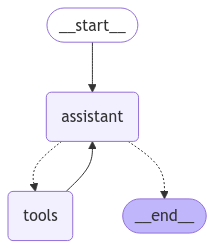

In [9]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))